In [867]:
import requests
import pandas as pd
import json
import xlsxwriter
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Idea:
 - First we will see the tops datas and few analysis. (Done)
 - We will try to see the dropdowns with states name and then plot of confirmed cases/ Active Cases/ Recovered/ Deceased
 - We can think of UI where the data is presented in normal manner.
 - We can see some campared data where we can compare data's with each others
 - Later we create a ML model which can predict the future by learning past.
 - If we can have the past data weekwise or month wise then we can say which state was careless in what period of time.

In [868]:
#getting the data from the API
response = requests.get('https://api.covid19india.org/state_district_wise.json')
#lets check the response
print(response.status_code)

200


In [869]:
#lets load the json data and try to find out if thisngs looks fine.
jsonRawData = json.loads(response.text)
currDistrict = jsonRawData['Uttar Pradesh']['districtData']['Agra']
currDistrict

{'notes': '',
 'active': 61,
 'confirmed': 25708,
 'migratedother': 0,
 'deceased': 453,
 'recovered': 25194,
 'delta': {'confirmed': 0, 'deceased': 0, 'recovered': 0}}

**Tips:** pd.to_excel has not solve our problem we will have to check the other solution as well, we will take the long route and use excel writter and later point of time we will read the same.

In [870]:
# pd.to_excel has not solve our problem for some reason, gotta take the long way, we will use the excel writter 
workbook = xlsxwriter.Workbook('todaysData.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0,0, 'States')
worksheet.write(0,1, 'District')
worksheet.write(0,2, 'Notes')
worksheet.write(0,3, 'Active')
worksheet.write(0,4, 'Confirmed')
worksheet.write(0,5, 'Migratedother')
worksheet.write(0,6, 'Deceased')
worksheet.write(0,7, 'Recovered')
worksheet.write(0,8, 'Delta')

# workbook.close()   

0

In [871]:
# A definition to convert the JSON data in excel.
def convertJSONToExcel(rawData):
    # print(rawData)
    i=0
    for stateName in rawData:
        for districtName in rawData[stateName]["districtData"]:
            i+=1
            for name in rawData[stateName]["districtData"][districtName]:
                worksheet.write(i, 0, stateName)
                worksheet.write(i, 1, districtName)
                worksheet.write(i, 2, rawData[stateName]["districtData"][districtName]["notes"])
                worksheet.write(i, 3, rawData[stateName]["districtData"][districtName]["active"])
                worksheet.write(i, 4, rawData[stateName]["districtData"][districtName]["confirmed"])
                worksheet.write(i, 5, rawData[stateName]["districtData"][districtName]["migratedother"])
                worksheet.write(i, 6, rawData[stateName]["districtData"][districtName]["deceased"])
                worksheet.write(i, 7, rawData[stateName]["districtData"][districtName]["recovered"])

convertJSONToExcel(jsonRawData);

In [872]:
workbook.close()

Till here we have our data in a excel form now lets begin our ML journey

===================================================================
===================================================================

In [873]:
# Now lets read the excel data and start our journry
rawDS = pd.read_excel('todaysData.xlsx')
firstDS=rawDS
rawDS.head()

,States,District,Notes,Active,Confirmed,Migratedother,Deceased,Recovered,Delta
0,State Unassigned,Unassigned,NaN,0,0,0,0,0,NaN
1,Andaman and Nicobar Islands,Nicobars,District-wise numbers are out-dated as cumulat...,0,0,0,0,0,NaN
2,Andaman and Nicobar Islands,North and Middle Andaman,District-wise numbers are out-dated as cumulat...,0,1,0,0,1,NaN
3,Andaman and Nicobar Islands,South Andaman,District-wise numbers are out-dated as cumulat...,19,51,0,0,32,NaN
4,Andaman and Nicobar Islands,Unknown,NaN,1,7426,0,128,7297,NaN


**Idea:** We will try to check the consolidated date and play with graphs

In [874]:
#lets create the consolidated dataset
consolidatedData = pd.DataFrame()
consolidatedData['States']=rawDS.States.sort_index().unique()
# #putting all active cases state wise
consolidatedData['Active'] = firstDS.groupby(["States"])["Active"].sum().values
#putting all confirmed cases state wise
consolidatedData['Confirmed'] = firstDS.groupby(["States"])["Confirmed"].sum().values
#putting all Migratedother cases state wise
consolidatedData['Migratedother'] = firstDS.groupby(["States"])["Migratedother"].sum().values
#putting all Deceased cases state wise
consolidatedData['Deceased'] = firstDS.groupby(["States"])["Deceased"].sum().values
#putting all Recovered cases state wise
consolidatedData['Recovered'] = firstDS.groupby(["States"])["Recovered"].sum().values
# consolidatedData.set_index('States',drop=True, inplace=True)
consolidatedData.head()




,States,Active,Confirmed,Migratedother,Deceased,Recovered
0,State Unassigned,20,7478,0,128,7330
1,Andaman and Nicobar Islands,35871,1899748,0,12815,1851062
2,Andhra Pradesh,3057,36937,0,176,33704
3,Arunachal Pradesh,15317,515981,1347,4632,486265
4,Assam,1539,722418,1,9599,711279


**MOTS:** We have the consolidated data and some insite also which looks fine.... \
But these insite is good as individuals, we won't be having any stuffy information untill we compare these data.

**IDEA** Now lets compare these data's then only we can see some insite.

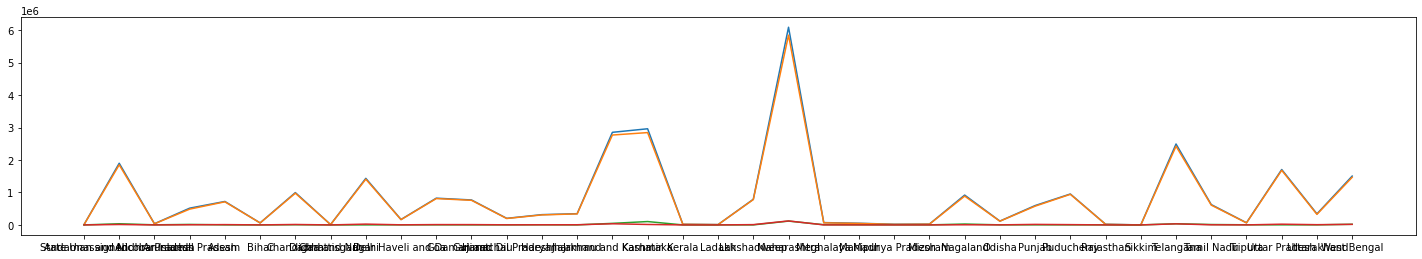

In [875]:
plt.figure(figsize=(25, 4)) 
plt.plot(consolidatedData.States, consolidatedData.Confirmed)
plt.plot(consolidatedData.States, consolidatedData.Recovered)
plt.plot(consolidatedData.States, consolidatedData.Active)
plt.plot(consolidatedData.States, consolidatedData.Deceased)
plt.show()

**MOTS:** Seems like we dont have much here also.....\
Frankly speaking more number of confirmed cases will have more number of Recovered cases and decesased cases also.

 - What we can find out here that is rate of recovery in any place, but that also be simple because that will be more for current most active cases place. which is also not giving much information.
 - Think about any states where the data shows that the rate is low dosnt mean that states is careless of anything, but it means in past might that states was handling good but now they are struggling right.
 - Suppose you have data which shows you the data timewise the we can tell that this perticular state is careless at this perticular time.

In [876]:
consolidatedData.set_index('States', drop=True, inplace=True)
consolidatedData.index

Index(['State Unassigned', 'Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Delhi', 'Dadra and Nagar Haveli and Daman and Diu', 'Goa', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Maharashtra',
       'Meghalaya', 'Manipur', 'Madhya Pradesh', 'Mizoram', 'Nagaland',
       'Odisha', 'Punjab', 'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana',
       'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
      dtype='object', name='States')

In [877]:
# here we are trying to get the data represented with the help of interact but at the state level
def stateData(states):
    consolidatedData.loc[states].plot(kind='bar')

interact(stateData, states=consolidatedData.index)

interactive(children=(Dropdown(description='states', options=('State Unassigned', 'Andaman and Nicobar Islands…

<function __main__.stateData(states)>

In [878]:
#lets create the consolidated dataset
consolidatedData_1 = pd.DataFrame()
consolidatedData_1['States']=rawDS.States.sort_index().unique()
# #putting all active cases state wise
consolidatedData_1['Active'] = firstDS.groupby(["States"])["Active"].sum().values
#putting all confirmed cases state wise
consolidatedData_1['Confirmed'] = firstDS.groupby(["States"])["Confirmed"].sum().values
#putting all Migratedother cases state wise
consolidatedData_1['Migratedother'] = firstDS.groupby(["States"])["Migratedother"].sum().values
#putting all Deceased cases state wise
consolidatedData_1['Deceased'] = firstDS.groupby(["States"])["Deceased"].sum().values
#putting all Recovered cases state wise
consolidatedData_1['Recovered'] = firstDS.groupby(["States"])["Recovered"].sum().values
# consolidatedData.set_index('States',drop=True, inplace=True)
consolidatedData_1.head()
# consolidatedData_1


,States,Active,Confirmed,Migratedother,Deceased,Recovered
0,State Unassigned,20,7478,0,128,7330
1,Andaman and Nicobar Islands,35871,1899748,0,12815,1851062
2,Andhra Pradesh,3057,36937,0,176,33704
3,Arunachal Pradesh,15317,515981,1347,4632,486265
4,Assam,1539,722418,1,9599,711279


In [890]:
# lets try the graph for all the consolidated data having to choose stages among
def topStatesInformation(stage):
    secondDS  = consolidatedData_1[['States',stage]]
    secondDS.set_index('States', drop=True, inplace=True)
    secondDS.nlargest(20, stage).plot(kind='bar', title ="Top states as per " + stage +  " cases", figsize=(25, 3),legend=True)
    for index,data in enumerate(secondDS[stage].nlargest(20)):
        plt.text(x=index ,y = data, s=f"{data}" , fontdict=dict(fontsize=10))
    

stages = (['Confirmed','Recovered','Active','Deceased'])

In [892]:
#lets check the interact now.
interact(topStatesInformation, stage = stages)


interactive(children=(Dropdown(description='stage', options=('Confirmed', 'Recovered', 'Active', 'Deceased'), …

<function __main__.topStatesInformation(stage)>